# **Shor's Algorithm Implementation**


# Explanation (Mathematics, Steps, and Practical Notes)

## Goal
Shor's algorithm finds a nontrivial factor of a composite integer $N$.  
If it finds any factor $1 < p < N$, we know $N$ is composite.  
If it fails after many attempts, we cannot conclude primality and must repeat or use other tests.

---

## Main idea (high level)

1. Reduce factoring to **order-finding**: pick random $a \in \{2,\dots,N-1\}$.  
   If $\gcd(a,N) > 1$ then we immediately found a factor.  
   Otherwise, let $r$ be the order of $a$ modulo $N$: the smallest $r>0$ such that  
   $a^r \equiv 1 \pmod{N}$.

2. If $r$ is even and $a^{r/2} \not\equiv -1 \pmod{N}$, then  
   $\gcd(a^{r/2} \pm 1, N)$  
   yields a nontrivial factor of $N$.

3. The quantum part uses a quantum circuit to estimate the period $r$ via QPE/QFT applied to a periodic state constructed from modular exponentiation.

---

## Algorithm steps (detailed)

1. **Classical pick:** choose random $a$ with $1 < a < N$.
2. **Check gcd:** compute $g = \gcd(a,N)$. If $1 < g < N$ you found a factor.
3. **Quantum order-finding:**
   - Prepare a superposition $\sum_x |x\rangle |1\rangle$ and apply modular exponentiation to obtain $\sum_x |x\rangle |a^x \bmod N\rangle$.
   - Apply the QFT to the first register and measure.  
     The measurement gives an $x$ such that $x/2^t$ approximates $k/r$, which can be processed using continued fractions.
4. **Classical postprocessing:** recover $r$ using continued fractions.  
   If $r$ is odd or $a^{r/2} \equiv -1 \pmod{N}$, repeat with a new $a$.
5. **Compute factor:** if $r$ is valid, compute $d = \gcd(a^{r/2} \pm 1, N)$. If $1 < d < N$ you found a factor.

---

## Complexity & resources (informal)

- Let $n = \lceil\log_2 N\rceil$.
- **Qubit count:** typically around $2n$ to $2n+3$ depending on the implementation.
- **Gate complexity:** modular exponentiation dominates and uses roughly $O(n^3)$ gates in naive versions.
- **Circuit depth:** large; reversible modular arithmetic is deep and stresses current hardware.
- **Success probability:** often above 50% for a random $a$; multiple runs increase reliability.

---

## Classical vs Quantum parts (where they appear in code)

- **Classical parts:**  
  `gcd(a,N)`, picking random $a$, testing $r$, computing $\gcd(a^{r/2} \pm 1, N)$.  
  These appear in plain Python in the notebook.

- **Quantum parts:**  
  Building modular exponentiation as a circuit, applying QFT/QPE, measuring, and converting results.  
  In our code, these appear inside the `run_shor_small` and `shor_factor` routines.

---

## Practical notes & limitations

- **Hardware practicality:**  
  Only very small $N$ (15, 21, etc.) run on real devices because circuit depth is large.  
  Simulators can go further but scale exponentially.

- **When to use classical emulation:**  
  For many inputs or moderate $N$, classical emulation of the *workflow* (random $a$, classical order-finding) is far faster.

- **Interpreting outputs:**
  - If a nontrivial factor is returned → algorithm correctly identified composite.
  - If no factor is returned → either $N$ is prime, or this run failed; repeat with a new $a$.

- **Always use classical checks:**  
  Quick gcd tests and trial division should always be combined with the quantum routine.

---

## Short bibliography / references

- P. Shor, *Polynomial-Time Algorithms for Prime Factorization and Discrete Logarithms on a Quantum Computer*, 1994.
- Qiskit documentation on Shor’s algorithm and example implementations.

---


In [2]:
import importlib
import sys
import subprocess

packages = ["qiskit", "qiskit_aer"]

for pkg in packages:
    spec = importlib.util.find_spec(pkg)
    if spec is None:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
    else:
        print(f"{pkg} is already installed.")


qiskit is already installed.
qiskit_aer is already installed.


## Cell 1

**Purpose:** load libraries and provide fast, reliable classical helpers used by the notebook (ground-truth primality and extracting the order `r` from measured phases).

**What it does (brief):**
- Imports standard Python and scientific packages: `math, time, random, statistics, numpy, pandas, matplotlib` for numeric work, timing, data handling and plotting.
- Imports Qiskit primitives: `QuantumCircuit, QuantumRegister, ClassicalRegister, transpile`, `UnitaryGate`, `AerSimulator`, and `QFTGate` — these are used later to build and run the quantum circuits.
- Sets plotting style (`mpl.rcParams`) so plots look clean and LaTeX-like.
- Defines `_DETERMINISTIC_BASES_64` — seven bases that make Miller–Rabin deterministic for **all** integers `< 2^64`.
- `is_prime_deterministic_upto_2pow64(n)` — a deterministic Miller–Rabin implementation (fast, exact primality test for 64-bit-range inputs). Used as the **ground-truth** `actual_is_prime` for evaluation.
- `continued_fraction_r(x, Q, max_denominator=None)` — uses Python `Fraction` to find a best rational approximation of `x/Q` and returns the **denominator** (candidate order `r`).
- `get_r_from_phase(measured_x, t, max_r=None)` — convenience wrapper: given a measured integer `measured_x` from `t` phase qubits, returns a candidate `r` by calling the continued-fraction helper.

**Why it’s needed:**  
Shor’s quantum part outputs phase measurements (integers). The classical parts in this cell:
1. Give the true primality for each test `n` (so you can measure accuracy), and  
2. Convert measured quantum phases into candidate orders `r` (essential for the classical postprocessing step that yields factors).


In [3]:
# Cell 1: imports and ground-truth primality helper
import math
import time
import random
import statistics
from fractions import Fraction
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFTGate

# plotting style
mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "font.size": 13
})

# Deterministic MR bases for n < 2^64 (ground truth)
_DETERMINISTIC_BASES_64 = [2, 325, 9375, 28178, 450775, 9780504, 1795265022]

def is_prime_deterministic_upto_2pow64(n: int) -> bool:
    """Deterministic Miller-Rabin for n < 2^64."""
    if n < 2:
        return False
    small_primes = (2,3,5,7,11,13,17,19,23,29)
    for p in small_primes:
        if n == p:
            return True
        if n % p == 0:
            return False
    s = 0
    d = n - 1
    while d % 2 == 0:
        d //= 2
        s += 1
    def check(a):
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            return True
        for _ in range(s - 1):
            x = (x * x) % n
            if x == n - 1:
                return True
        return False
    for a in _DETERMINISTIC_BASES_64:
        if a % n == 0:
            return True
        if not check(a):
            return False
    return True

# Continued fraction helper to recover denominator r
def continued_fraction_r(x, Q, max_denominator=None):
    frac = Fraction(x, Q).limit_denominator(max_denominator or Q)
    return frac.denominator

def get_r_from_phase(measured_x, t, max_r=None):
    Q = 2**t
    return continued_fraction_r(measured_x, Q, max_denominator=max_r)


## Cell 2

**Purpose:**  
This cell constructs the unitary operation \( U_a \) used in Shor’s algorithm, where:

\[
$U_a \lvert y \rangle = \lvert a \cdot y \bmod N \rangle$.
\]

This is the core modular-multiplication step needed for quantum order finding.

---

### What the function does:

**`build_Ua_matrix(a, N)`**
- Determines how many qubits (`n_target`) are needed to represent numbers up to $N$.
- Builds a full $2^{\,n_{\text{target}}} \times 2^{\,n_{\text{target}}}$ **unitary matrix**.
- For each basis state $|y\rangle$:
  - If $y < N$: maps it to $|(a \cdot y) \bmod N\rangle$.
  - If $y \ge N$: leaves it unchanged (identity), ensuring the whole matrix is unitary.
- Returns:
  - the matrix `U` as a NumPy array, and  
  - the number of target qubits required (`n_target`).


---

### Why it’s needed:

Shor’s algorithm requires controlled powers of $U_a$ (i.e., $U_a^{2^j}$).  
By explicitly constructing $U_a$ as a matrix, we can wrap it as a `UnitaryGate` in Qiskit and use it in controlled form — this makes the implementation simple and reliable for **small values of $N$**.


(For large N this matrix becomes too big, but for our test values it's ideal.)


In [4]:
# Cell 2: Build full unitary for multiplication by a (works for small N)
def build_Ua_matrix(a, N):
    """
    Build full 2^n x 2^n permutation matrix for |y> -> |a*y mod N> for y in [0..N-1].
    For states y >= N we leave them unchanged (identity).
    Returns matrix U (numpy array) and n_target (# target qubits).
    """
    if N < 2:
        raise ValueError("N must be >= 2")
    n_target = math.ceil(math.log2(max(2, N)))
    dim = 1 << n_target
    U = np.zeros((dim, dim), dtype=complex)
    for y in range(dim):
        if y < N:
            mapped = (a * y) % N
            U[mapped, y] = 1.0
        else:
            U[y, y] = 1.0
    return U, n_target


## Cell 3

**Purpose:**  
This cell builds and runs the **quantum order-finding circuit** used inside Shor’s algorithm.  
It performs:  
1. Superposition on the evaluation register,  
2. Controlled applications of $U_a^{2^j}$,  
3. Inverse QFT,  
4. Measurement,  
and returns the measured values and candidate orders.

---

## What the function does (brief)

### 1. **Setup**
- If `a` (the base) isn’t given, it randomly picks one coprime to `N`.
- Builds the unitary matrix $U_a$ using the helper from Cell 2.
- Creates:
  - `eva` (t qubits) — evaluation register for phase estimation  
  - `tgt` (n_target qubits) — holds the modular multiplication state  
  - `cri` (t classical bits) — stores measurement outcomes  

### 2. **Initialization**
- Puts the target register into state $|1\rangle$.  
- Applies Hadamards to all `t` evaluation qubits to create equal superposition.

### 3. **Controlled powers of U**
For each evaluation qubit $j$:

**apply controlled $U_a^{2^j}$**

- Computes the matrix power $U_a^{2^j}$  
- Wraps it into a `UnitaryGate`  
- Applies the controlled version using `eva[j]` as the control  

This step forms the quantum phase estimation core of Shor’s algorithm.

### 4. **Inverse QFT**
Applies the inverse quantum Fourier transform $ \text{QFT}^{-1} $ on the evaluation register  
to convert accumulated phases into measurable peaks.

### 5. **Measurement + Simulation**
- Measures all evaluation qubits into classical bits.  
- Transpiles and runs the circuit on the Aer simulator.  
- Converts bitstrings into integer values $x$.

### 6. **Extract r candidates**
Sorts the measurement histogram to find the most likely $x$ values and converts them into order candidates using:

$r \approx \text{denominator of } (x / 2^t)$

---

## What the function returns

A dictionary containing:
- `a` — the base used  
- `t` — number of evaluation qubits  
- `histogram` — measurements $x \rightarrow$ counts  
- `candidates` — list of $(x,\ \text{count},\ r_{\text{candidate}})$  
- `counts` — raw Qiskit counts  
- `qc` — the constructed quantum circuit  

---

**In short:**  
This cell implements the **quantum phase estimation** portion of Shor’s algorithm, applying the required controlled powers of $U_a$ and extracting measurement data needed for order finding.


In [5]:
# Cell 3: run_shor_small — build circuit with controlled U^{2^j} using full-unitary gates

def run_shor_small(N, a=None, t=6, shots=512, simulator=None):
    """
    Run small Shor order-finding (matrix-based) for given N and base a.
    Returns dict with fields: a, t, histogram, candidates (list of (x,count,r_candidate)), counts, qc.
    """
    if simulator is None:
        simulator = AerSimulator()

    # pick a if not given
    if a is None:
        while True:
            a = random.randrange(2, N)
            if math.gcd(a, N) == 1:
                break
    if math.gcd(a, N) != 1:
        return {'error': f'gcd(a,N) != 1 -> {math.gcd(a,N)}', 'a': a}

    U_mat, n_target = build_Ua_matrix(a, N)
    eva = QuantumRegister(t, name='ev')
    tgt = QuantumRegister(n_target, name='tgt')
    cri = ClassicalRegister(t, name='c')
    qc = QuantumCircuit(eva, tgt, cri)

    # initialize target to |1>
    qc.x(tgt[0])
    # Apply Hadamards to evaluation register
    qc.h(eva)

    # Controlled-U^{2^j} for j in [0..t-1]
    for j in range(t):
        power = 2**j
        U_pow = np.linalg.matrix_power(U_mat, power)
        U_gate = UnitaryGate(U_pow, label=f"U^{power}")
        cU = U_gate.control(1)
        qargs = [eva[j]] + [tgt[k] for k in range(n_target)]
        qc.append(cU, qargs)

    # inverse QFT on evaluation register
    qft_dg = QFTGate(t).inverse()
    qc.append(qft_dg, eva[:])

    # measure evaluation register
    qc.measure(eva, cri)

    # transpile and run
    qc = transpile(qc, simulator)
    job = simulator.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)

    # counts: mapping bitstring -> count (classical bits length == t)
    # parse bitstrings robustly (take last t bits if extras)
    histogram = {}
    for bitstr, cnt in counts.items():
        b = bitstr.replace(" ", "")
        if len(b) != t:
            b = b[-t:]
        x = int(b, 2)
        histogram[x] = histogram.get(x, 0) + cnt

    # compute candidate r from top outcomes
    sorted_counts = sorted(histogram.items(), key=lambda kv: kv[1], reverse=True)
    candidates = []
    for x, cnt in sorted_counts[:min(6, len(sorted_counts))]:
        r_cand = get_r_from_phase(x, t, max_r=N)
        candidates.append((x, cnt, r_cand))

    return {"a": a, "t": t, "histogram": histogram, "candidates": candidates, "counts": counts, "qc": qc}


## Cell 4

**Purpose:**  
Classical post-processing to convert an order $r$ into a factor (when possible), and the high-level `shor_factor` function that runs the full factoring loop (classical checks + quantum order-finding) and always returns a consistent result dictionary.

---

### `try_factor_from_r(N, a, r)`
- **Inputs:** integer $N$, base $a$, and a candidate order $r$.
- **What it does:**
  - Ignores `None` or odd values of $r$.
  - Computes $a^{r/2} \bmod N$.
  - If $a^{r/2} \equiv -1 \pmod{N}$, the order is not useful and it stops.
  - Otherwise computes $\gcd(a^{r/2} - 1, N)$ and $\gcd(a^{r/2} + 1, N)$.
- **Output:** returns a non-trivial factor of $N$ if found, otherwise `None`.

---

### `shor_factor(N, t=None, shots=512, tries=4, simulator=None)`
- **High-level behavior:** tries to factor $N$ by repeating up to `tries` times:
  1. Picks random $a$ and checks $\gcd(a, N)$ (may immediately give a factor).
  2. Runs `run_shor_small` to perform quantum order-finding for that $a$.
  3. Converts the top measured phases into order candidates $r$, and calls `try_factor_from_r` to extract a factor.
- **Defaults / practical limits:**
  - If `t` is not given, sets $t = \min(2 \cdot \lceil\log_2 N\rceil,\ 10)$ to balance precision and circuit size.
  - `shots` and `tries` tune statistical accuracy vs runtime.
- **Error handling:**  
  If `run_shor_small` returns an error, the wrapper produces a result dict with `method="error"`.

- **Return value:** always a dictionary containing:
  ```json
  {
    "factor": int or None,
    "method": "gcd" | "quantum" | "perfect_square" | "none" | "error",
    "a": base used or None,
    "r": candidate order or None,
    "x": measured phase integer or None,
    "qc": quantum circuit (optional),
    "error": error message or None
  }


In [6]:
# Cell 4: classical attempt to extract factor from r and consistent shor_factor that returns a dict
def try_factor_from_r(N, a, r):
    if r is None:
        return None
    if r % 2 == 1:
        return None
    apow = pow(a, r//2, N)
    if (apow + 1) % N == 0:
        return None
    g1 = math.gcd(apow - 1, N)
    g2 = math.gcd(apow + 1, N)
    for g in (g1, g2):
        if 1 < g < N:
            return g
    return None

def shor_factor(N, t=None, shots=512, tries=4, simulator=None):
    """
    High-level Shor: repeat up to tries, returns dict with keys:
    factor (int|None), method, a, r, x, qc, error
    """
    if simulator is None:
        simulator = AerSimulator()

    # quick perfect-square check
    if math.isqrt(N)**2 == N:
        return {'factor': math.isqrt(N), 'method': 'perfect_square', 'a': None, 'r': None, 'x': None, 'qc': None, 'error': None}

    # choose default t if not provided: use ~2*ceil(log2 N) for decent resolution, but cap to avoid huge circuits
    if t is None:
        nbits = math.ceil(math.log2(N))
        t = min(2*nbits, 10)  # cap t to 10 to limit circuit size; adjust if needed

    for attempt in range(tries):
        # classical gcd check while picking a
        while True:
            a = random.randrange(2, N)
            g = math.gcd(a, N)
            if 1 < g < N:
                return {'factor': g, 'method': 'gcd', 'a': a, 'r': None, 'x': None, 'qc': None, 'error': None}
            if g == 1:
                break

        # run quantum order-finding
        res = run_shor_small(N, a=a, t=t, shots=shots, simulator=simulator)
        if res is None:
            continue
        if 'error' in res and res['error'] is not None:
            return {'factor': None, 'method': 'error', 'a': a, 'r': None, 'x': None, 'qc': res.get('qc'), 'error': res.get('error')}

        for x, cnt, r_cand in res['candidates']:
            f = try_factor_from_r(N, a, r_cand)
            if f is not None and 1 < f < N:
                return {'factor': f, 'method': 'quantum', 'a': a, 'r': r_cand, 'x': x, 'qc': res.get('qc'), 'error': None}
    return {'factor': None, 'method': 'none', 'a': None, 'r': None, 'x': None, 'qc': None, 'error': None}


## Cell 5

**Purpose:**  
Run the full Shor benchmark on your selected test numbers and collect all results needed for analysis.

---

### What it does (brief)

- Defines `test_numbers` — the list of integers you want to test.
- Creates the Aer `statevector` simulator and an empty `results` list.
- For each number `n`:
  1. Starts a timer.
  2. Calls `shor_factor(n, t=None, shots=shots, tries=tries, simulator=sim)` — the high-level routine that performs classical checks and quantum order-finding.
  3. Stops the timer to compute the runtime.
  4. Computes `actual_prime` using the deterministic Miller–Rabin function (ground truth).
  5. Decides whether Shor’s output matches the truth (`success`).
  6. Stores a dictionary with all relevant information:  
     `n`, `bitlen`, `actual_is_prime`, `shor_factor`, `runtime_s`, `method`, `a_used`, `r`, `x`, `success`, `error`.
  7. Prints a summary line showing factor, runtime, success, and method.

---

### Parameters you can tune

- `shots`: number of circuit shots (less → faster, more → more stable).
- `tries`: how many different random bases `a` to try per number.
- `t`: number of phase-estimation qubits. If left as `None`, `shor_factor` chooses a default based on $2 \cdot \lceil \log_2 N \rceil$ but capped to avoid huge circuits.

---

### What ends up in `results`

A list of dictionaries that will later become a DataFrame containing:

- the requested **3-column table** (`n`, `actual_is_prime`, `shor_factor`),  
- runtime per number,  
- metadata about how the factor was found (`gcd`, `quantum`, `none`, etc.),  
- quantum measurement and order candidate details,  
- success status for accuracy calculation.

---

### Why this cell matters

This is the **main data-collection loop** of your benchmark.  
Everything in the later summary table and all the plots (runtime trends, accuracy trends) comes from the values generated here.


In [7]:
# Cell 5: your test numbers and run
test_numbers = [
    3, 5, 7, 11, 13,          # small primes
    15, 21, 27, 33, 35,       # small composites
    39, 51, 55, 57, 65,       # easy semiprimes
    85                                 # composite semiprimes
]

sim = AerSimulator(method='statevector')
results = []
# parameters you can tune for speed vs accuracy
shots = 512   # decrease to speed up
tries = 4     # how many random a attempts per N
for n in test_numbers:
    print("Running N =", n)
    t0 = time.perf_counter()
    out = shor_factor(n, t=None, shots=shots, tries=tries, simulator=sim)
    t1 = time.perf_counter()
    factor = out.get('factor')
    actual_prime = None
    if n < (1<<64):
        actual_prime = is_prime_deterministic_upto_2pow64(n)
    else:
        actual_prime = False  # fallback, but your test set is small

    alg_says_prime = (factor is None)
    success = None
    if actual_prime is not None:
        success = (alg_says_prime == actual_prime)

    results.append({
        'n': n,
        'bitlen': n.bit_length(),
        'actual_is_prime': actual_prime,
        'shor_factor': factor,
        'runtime_s': t1 - t0,
        'method': out.get('method'),
        'a_used': out.get('a'),
        'r': out.get('r'),
        'x': out.get('x'),
        'success': success,
        'error': out.get('error')
    })
    print(f" -> factor={factor} | time={t1-t0:.3f}s | success={success} | method={out.get('method')}")


Running N = 3
 -> factor=None | time=1.035s | success=True | method=none
Running N = 5
 -> factor=None | time=0.833s | success=True | method=none
Running N = 7
 -> factor=None | time=1.418s | success=True | method=none
Running N = 11
 -> factor=None | time=5.106s | success=True | method=none
Running N = 13
 -> factor=None | time=9.530s | success=True | method=none
Running N = 15
 -> factor=3 | time=1.055s | success=True | method=quantum
Running N = 21
 -> factor=3 | time=1.442s | success=True | method=quantum
Running N = 27
 -> factor=3 | time=0.000s | success=True | method=gcd
Running N = 33
 -> factor=3 | time=0.000s | success=True | method=gcd
Running N = 35
 -> factor=5 | time=0.000s | success=True | method=gcd
Running N = 39
 -> factor=3 | time=105.763s | success=True | method=quantum
Running N = 51
 -> factor=3 | time=38.876s | success=True | method=quantum
Running N = 55
 -> factor=11 | time=0.000s | success=True | method=gcd
Running N = 57
 -> factor=3 | time=0.000s | success=T

## Cell 6

**Purpose:**  
Convert the collected results into a DataFrame and display both the main evaluation table and detailed diagnostic information. Also computes summary statistics such as total tests and overall accuracy.

---

### What it does:

1. **Create a DataFrame**
   ```python
   df = pd.DataFrame(results)


In [8]:
# Cell 6: display dataframe and summary
df = pd.DataFrame(results)
# Show the requested 3-column plus runtime & success
display(df[['n','actual_is_prime','shor_factor','runtime_s','success']])

# Extended diagnostics
display(df[['n','bitlen','actual_is_prime','shor_factor','runtime_s','method','a_used','r','x','success','error']])

total = len(df)
known = df['success'].notna().sum()
accuracy = df['success'].dropna().mean() if known>0 else None
print(f"Total tested: {total}; Ground-truth known for: {known}; Accuracy (where known): {accuracy}")


,n,actual_is_prime,shor_factor,runtime_s,success
0,3,True,NaN,1.035125,True
1,5,True,NaN,0.832918,True
2,7,True,NaN,1.418196,True
3,11,True,NaN,5.105653,True
4,13,True,NaN,9.529877,True
5,15,False,3.0,1.055012,True
6,21,False,3.0,1.442065,True
7,27,False,3.0,0.000020,True
8,33,False,3.0,0.000004,True
9,35,False,5.0,0.000003,True


,n,bitlen,actual_is_prime,shor_factor,runtime_s,method,a_used,r,x,success,error
0,3,2,True,NaN,1.035125,none,NaN,NaN,NaN,True,None
1,5,3,True,NaN,0.832918,none,NaN,NaN,NaN,True,None
2,7,3,True,NaN,1.418196,none,NaN,NaN,NaN,True,None
3,11,4,True,NaN,5.105653,none,NaN,NaN,NaN,True,None
4,13,4,True,NaN,9.529877,none,NaN,NaN,NaN,True,None
5,15,4,False,3.0,1.055012,quantum,8.0,4.0,192.0,True,None
6,21,5,False,3.0,1.442065,quantum,13.0,2.0,512.0,True,None
7,27,5,False,3.0,0.000020,gcd,21.0,NaN,NaN,True,None
8,33,6,False,3.0,0.000004,gcd,15.0,NaN,NaN,True,None
9,35,6,False,5.0,0.000003,gcd,15.0,NaN,NaN,True,None


Total tested: 16; Ground-truth known for: 16; Accuracy (where known): 1.0


## Cell 7

This cell creates three plots to visualize the performance of Shor’s algorithm:

1. **Runtime per number**  
   - Scatter plot showing how long Shor takes for each tested integer.

2. **Bit-length vs mean runtime**  
   - Groups numbers by their bit-length and plots the average runtime (with deviation).

3. **Accuracy vs bit-length**  
   - Shows how often Shor was correct for each bit-length group.

In short: this cell plots **runtime** and **accuracy** trends for all the test numbers you ran.


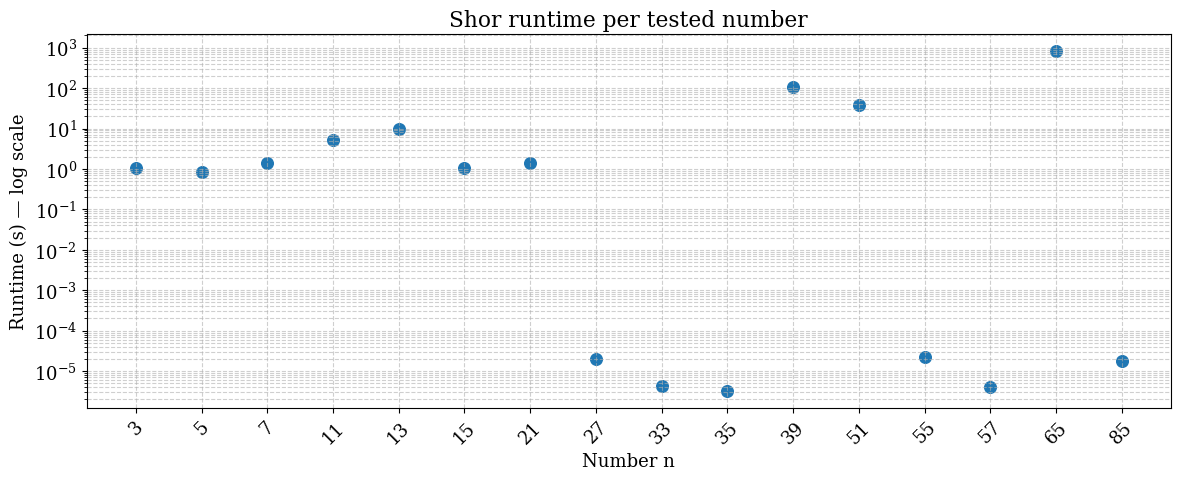

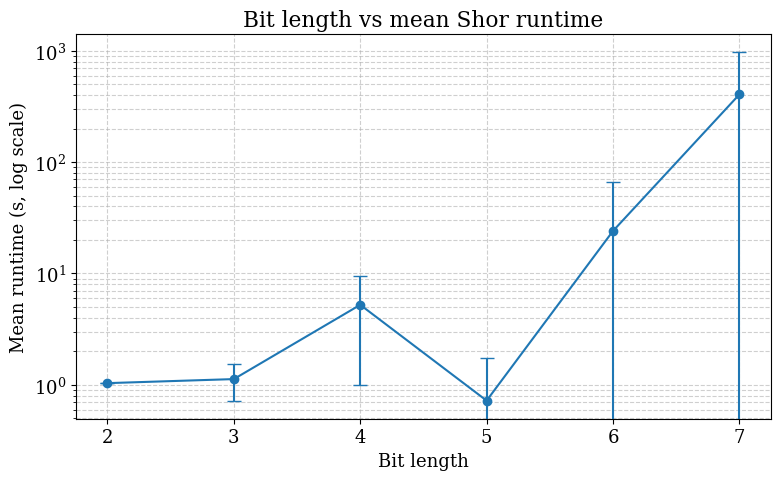

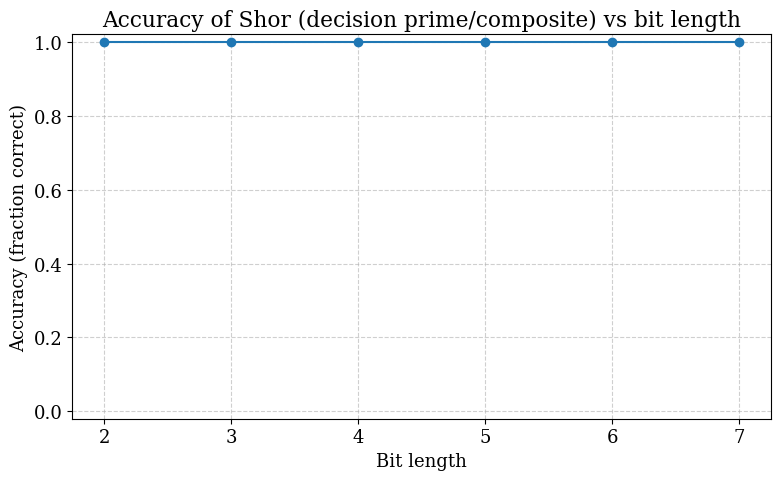

In [9]:
# Cell 7: plots

# A: runtime per number (log scale y)
plt.figure(figsize=(12,5))
xs = [str(int(r['n'])) for r in results]
ys = [r['runtime_s'] for r in results]
plt.scatter(xs, ys, s=70)
plt.yscale('log')
plt.xlabel("Number n")
plt.ylabel("Runtime (s) — log scale")
plt.title("Shor runtime per tested number")
plt.xticks(rotation=45)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

# B: bit-length vs mean runtime (+std)
by_bit = defaultdict(list)
for r in results:
    by_bit[r['bitlen']].append(r['runtime_s'])
bitlens = sorted(by_bit.keys())
means = [statistics.mean(by_bit[b]) for b in bitlens]
stds = [statistics.stdev(by_bit[b]) if len(by_bit[b])>1 else 0.0 for b in bitlens]

plt.figure(figsize=(8,5))
plt.errorbar(bitlens, means, yerr=stds, fmt='o-', capsize=5)
plt.yscale('log')
plt.xlabel("Bit length")
plt.ylabel("Mean runtime (s, log scale)")
plt.title("Bit length vs mean Shor runtime")
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

# C: accuracy vs bit length
# compute accuracy per bitlen where success known
acc_b = []
acc_v = []
for b in bitlens:
    group = [r for r in results if r['bitlen']==b and r['success'] is not None]
    if len(group)>0:
        acc = sum(1 for g in group if g['success']) / len(group)
        acc_b.append(b)
        acc_v.append(acc)

plt.figure(figsize=(8,5))
if acc_b:
    plt.plot(acc_b, acc_v, marker='o')
    plt.ylim(-0.02,1.02)
    plt.xlabel("Bit length")
    plt.ylabel("Accuracy (fraction correct)")
    plt.title("Accuracy of Shor (decision prime/composite) vs bit length")
    plt.grid(True, ls='--', alpha=0.6)
else:
    plt.text(0.5,0.5,"No accuracy values available", ha='center')
plt.tight_layout()
plt.show()
